<a href="https://colab.research.google.com/github/ConnorK747/COSC526SpookyAuthors/blob/Richa--Satge2/Part_2_spooky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install pyspark


In [20]:
from google.colab import files
uploaded = files.upload()  # Select the kaggle.json file from your computer


Saving kaggle.json to kaggle.json


In [21]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"


In [22]:
!pip install kaggle
!kaggle competitions download -c spooky-author-identification


  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 147MB/s]


In [23]:
import zipfile

with zipfile.ZipFile('spooky-author-identification.zip', 'r') as zip_ref:
    zip_ref.extractall('Datasets')


In [24]:
# Step 1: Import necessary libraries
from google.colab import files
import os
import shutil

# Step 2: Upload files
uploaded = files.upload()  # Choose train.csv and test.csv when prompted

# Step 3: Create a folder named 'Datasets'
os.makedirs('Datasets', exist_ok=True)  # This creates the folder if it doesn't exist

# Step 4: Move the uploaded files to the 'Datasets' folder
for filename in uploaded.keys():
    shutil.move(filename, f'Datasets/{filename}')  # Move each uploaded file to the Datasets folder

# Step 5: Check that the files are now in the 'Datasets' folder
print("Files moved to 'Datasets' folder:")
print(os.listdir('Datasets'))  # List the files in the Datasets folder


Saving spooky-author-identification.zip to spooky-author-identification (1).zip
Files moved to 'Datasets' folder:
['train.zip', 'spooky-author-identification (1).zip', 'sample_submission.zip', 'test.zip']


In [25]:
import zipfile

# Step 1: Extract train.zip
with zipfile.ZipFile('Datasets/train.zip', 'r') as zip_ref:
    zip_ref.extractall('Datasets/train')

# Step 2: Extract test.zip
with zipfile.ZipFile('Datasets/test.zip', 'r') as zip_ref:
    zip_ref.extractall('Datasets/test')

# Step 3: Check the extracted files
print("Train Files:", os.listdir('Datasets/train'))
print("Test Files:", os.listdir('Datasets/test'))

# Step 4: Create a Spark session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("SpookyAuthorIdentification").getOrCreate()

# Step 5: Load training data into a DataFrame
try:
    train_df = spark.read.csv('Datasets/train/train.csv', header=True, inferSchema=True)
    train_df.printSchema()
    train_df.show(5)
except Exception as e:
    print("Error loading the CSV file:", e)

# Step 6: Load test data into a DataFrame
try:
    test_df = spark.read.csv('Datasets/test/test.csv', header=True, inferSchema=True)
    test_df.printSchema()
    test_df.show(5)
except Exception as e:
    print("Error loading the CSV file:", e)


Train Files: ['train.csv']
Test Files: ['test.csv']
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)

+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



In [26]:
#Print num rows and cols in the training set
train_row_count = train_df.count()
train_column_count = len(train_df.columns)
print(f"Training Data - Rows: {train_row_count}, Columns: {train_column_count}")

Training Data - Rows: 19579, Columns: 3


In [27]:
#Print num rows and cols in the test set
test_row_count = test_df.count()
test_column_count = len(test_df.columns)
print(f"Test Data - Rows: {test_row_count}, Columns: {test_column_count}")

Test Data - Rows: 8392, Columns: 2


In [28]:
#Check for missing values (There are none)
train_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()
test_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()

+---+----+------+
| id|text|author|
+---+----+------+
|  0|   0|     0|
+---+----+------+

+---+----+
| id|text|
+---+----+
|  0|   0|
+---+----+



In [29]:
#Create sentence length column
train_df = train_df.withColumn("sentence_length", F.length(F.col("text")))
train_df.select("sentence_length").describe().show()

+-------+------------------+
|summary|   sentence_length|
+-------+------------------+
|  count|             19579|
|   mean|139.99765054395016|
| stddev|101.25452331007808|
|    min|                 5|
|    max|              3682|
+-------+------------------+



In [30]:
#Use tokenizer to tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_train_df = tokenizer.transform(train_df)

#Print tokenized output
tokenized_train_df.select("text", "words").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                   |words                                                                                                                                                                                                                                                              

In [31]:
#Create an instance of StopWordsRemover and use it to filter the tokens and remove stop words
#The new filtered tokens are placed in a new column "filtered_words"
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
cleaned_train_df = remover.transform(tokenized_train_df)

#Print the cleaned output
cleaned_train_df.select("words", "filtered_words").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                                                                                                                                            |filtered_words                                                                                                                                                                              |
+---------------------------------------------------------------------

# Satge 2 Feature Extraction:
we will convert the cleaned text into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency).

In [32]:
# Step 1: Install necessary libraries
!pip install --upgrade pyspark

# Step 2: Import necessary modules
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, Normalizer
from pyspark.ml import Pipeline
from google.colab import files
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## encoding authors


# Step 3: Upload your CSV file
uploaded = files.upload()

# Step 4: Initialize Spark session
spark = SparkSession.builder.appName("TextProcessing").getOrCreate()

# Step 5: Load training data from the uploaded file
train_df = spark.read.csv("train.csv", header=True, inferSchema=True)

# Step 6: Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tokens_df = tokenizer.transform(train_df)

# Step 7: Stop words removal
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
filtered_df = remover.transform(tokens_df)

# Step 8: TF-IDF calculation using CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

# Step 9: Normalization
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")

# Step 10: Create and apply pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf, normalizer])
processed_data = pipeline.fit(train_df).transform(train_df)

# Step 11: Show the final processed DataFrame with normalized features
processed_data.select("normalized_features").show(truncate=False)


Saving train.csv to train (6).csv
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Stage 3: machine learning

In [33]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## encoding authors
processed_data = processed_data.withColumn(
    "author",
    F.when(F.col("author") == "EAP", 0)
    .when(F.col("author") == "HPL", 1)
    .when(F.col("author") == "MWS", 2)
    .otherwise(None)
)

ml_df = processed_data.filter(F.col("author").isNotNull())

train_data, test_data = ml_df.randomSplit([0.8, 0.2], seed=42)

## grabbing normalized_features and author only for test data
test_data = test_data.select("normalized_features", "author")

train_data.show(5)

+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     id|                text|author|              tokens|     filtered_tokens|   vectorized_tokens|               tfidf| normalized_features|
+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|id00001|Idris was well co...|     2|[idris, was, well...|[idris, well, con...|(42876,[30,565,15...|(42876,[30,565,15...|(42876,[30,565,15...|
|id00002|I was faint, even...|     1|[i, was, faint,, ...|[faint,, even, fa...|(42876,[2,12,49,1...|(42876,[2,12,49,1...|(42876,[2,12,49,1...|
|id00004|He might see, per...|     0|[he, might, see,,...|[might, see,, per...|(42876,[0,4,26,19...|(42876,[0,4,26,19...|(42876,[0,4,26,19...|
|id00005|All obeyed the Lo...|     2|[all, obeyed, the...|[obeyed, lord, pr...|(42876,[85,154,61...|(42876,[85,154,61...|(42876,[85,154,61...|

In [34]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## encoding authors
# Initialize LogisticRegression model
lr = LogisticRegression(featuresCol="normalized_features", labelCol="author")

# Train the model
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="author", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7367680180180181


Part 2: Achieving 80% accuracy

In [37]:
from pyspark.ml.classification import NaiveBayes

# Initialize NaiveBayes
nb = NaiveBayes(featuresCol="normalized_features", labelCol="author")

# Train the Naive Bayes model
nb_model = nb.fit(train_data)

# Make predictions
nb_predictions = nb_model.transform(test_data)

# Evaluate accuracy
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")


Naive Bayes Accuracy: 0.80


In [38]:
## Confusion Matrix
## Shows prediction distribution
## For example, our model prediction of correctly 0 - 0 or EAP - EAP makes up 28% of all predictions
## Our True positives add up to the above accuracy score of ~74% which is well above the 50% threshold


confusion_matrix = predictions.groupBy("author", "prediction").count().orderBy("author", "prediction")
total_predictions = predictions.count()

confusion_matrix = confusion_matrix.withColumn(
    "percentage",
    (F.col("count") / total_predictions) * 100
)

confusion_matrix = confusion_matrix.orderBy("author", "prediction")
confusion_matrix.show()

+------+----------+-----+------------------+
|author|prediction|count|        percentage|
+------+----------+-----+------------------+
|     0|       0.0| 1025| 28.85698198198198|
|     0|       1.0|  150| 4.222972972972973|
|     0|       2.0|  207| 5.827702702702703|
|     1|       0.0|  177| 4.983108108108108|
|     1|       1.0|  786| 22.12837837837838|
|     1|       2.0|  121|3.4065315315315314|
|     2|       0.0|  187| 5.264639639639639|
|     2|       1.0|   93|2.6182432432432434|
|     2|       2.0|  806|22.691441441441444|
+------+----------+-----+------------------+



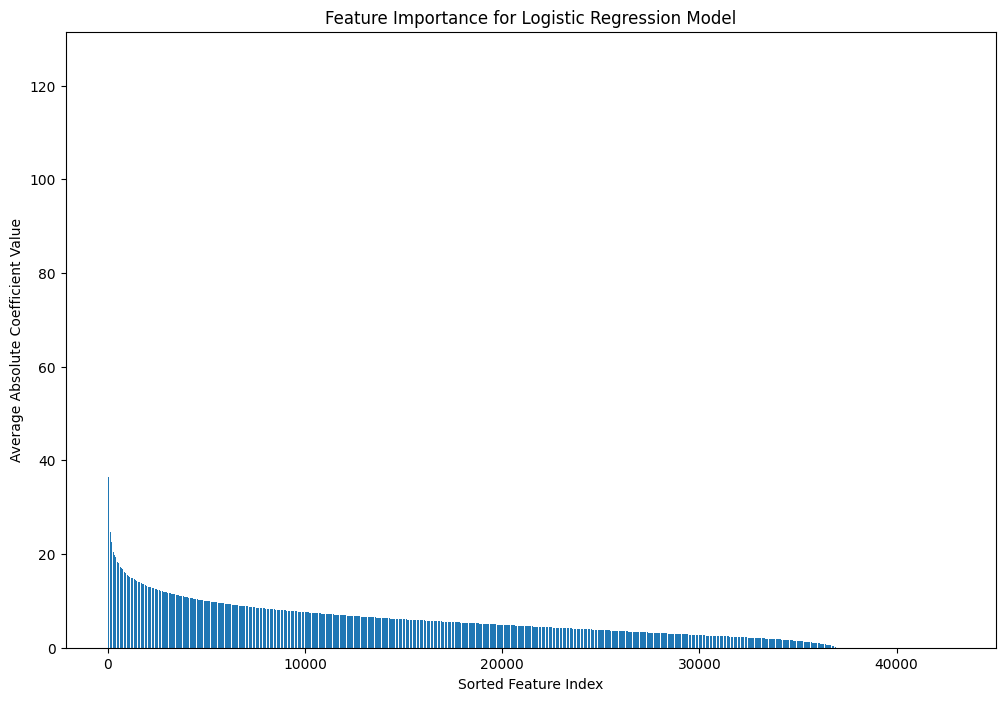

In [39]:
import numpy as np
import matplotlib.pyplot as plt


#Extract the coefficient matrix
feature_importance_matrix = lr_model.coefficientMatrix.toArray()

#Take the average absolute value across all classes to get a general sense of feature importance.
feature_importance = np.mean(np.abs(feature_importance_matrix), axis=0)

#Sort the feature importances by absolute value
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]

#Plot sorted feature importances
plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(sorted_importance)), sorted_importance)
plt.xlabel("Sorted Feature Index")
plt.ylabel("Average Absolute Coefficient Value")
plt.title("Feature Importance for Logistic Regression Model")
plt.show()

# Part 2  : 80% accuracy with the Naive Bayes classifier

In [40]:
from pyspark.ml.classification import NaiveBayes

# Initialize NaiveBayes
nb = NaiveBayes(featuresCol="normalized_features", labelCol="author")

# Train the Naive Bayes model
nb_model = nb.fit(train_data)

# Make predictions
nb_predictions = nb_model.transform(test_data)

# Evaluate accuracy
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")


Naive Bayes Accuracy: 0.80
